# Using submodel sei-cracks in PyBaMM
In this notebook we show how to use the sei-crack submodle for additional SEI growth on cracks in the anode. To see all of the models and submodels available in PyBaMM, please take a look at the documentation [here](https://pybamm.readthedocs.io/en/latest/source/models/index.html).

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


When you load a model in PyBaMM it builds by default. Building the model sets all of the model variables and sets up any variables which are coupled between different submodels: this is the process which couples the submodels together and allows one submodel to access variables from another. If you would like to swap out a submodel in an exisitng battery model you need to load it without building it by passing the keyword `build=False`

In [2]:
model = pybamm.lithium_ion.SPMe(
    build=False, options={"particle": "Fickian diffusion", "sei":"solvent-diffusion limited", "sei film resistance":"distributed", "sei porosity change":True}
)

This collects all of the submodels which make up the SPMe, but doesn't build the model. Here it is applicable to other types of battery models, e.g. SPM or DFN. 

To change a submodel you simply update the dictionary entry. Here the submodels "CrackPropagation" and "SEIonCracks" are both applicable to negative and positive electrodes, by replacing negative with positive respectively.

Building the model also sets up the equations, boundary and initial conditions for the model.

In [3]:
model.submodels["negative particle cracking"] = pybamm.particle_cracking.CrackPropagation(
    model.param, "Negative"
)
model.submodels["negative sei on cracks"] = pybamm.sei.SEIonCracks(
    model.param, "Negative"
)
# model.build_model()

We can get the default parameters for the model and update them with the parameters required by the cracking model. For some parameter sets including mechanical parameters, this command is not necessary.

In [4]:
param = model.default_parameter_values
chemistry = pybamm.parameter_sets.Chen2020
param = pybamm.ParameterValues(chemistry=chemistry)
param.update({"Initial concentration in negative electrode [mol.m-3]": 29866})
param.update({"Initial concentration in positive electrode [mol.m-3]": 14778})
param.update({"Maximum concentration in negative electrode [mol.m-3]": 33133})
param.update({"Maximum concentration in positive electrode [mol.m-3]": 56840})
param.update({"Negative electrode diffusivity [m2.s-1]": 6e-15}) #6e-15 good value
param.update({"Negative current collector surface heat transfer coefficient [W.m-2.K-1]": 0.1, 
"Positive current collector surface heat transfer coefficient [W.m-2.K-1]": 0.1}, check_already_exists=False)
param.update({"Total heat transfer coefficient [W.m-2.K-1]": 0.1})
param.update({"Ambient temperature [K]": 298.15})
param.update({"Initial temperature [K]": 298.15})
param.update({"Initial inner SEI thickness [m]": 0})
param.update({"Inner SEI reaction proportion": 0})
param.update({"Outer SEI solvent diffusivity [m2.s-1]": 2.5e-22*100})
param2 = param

# add mechanical properties
import pandas as pd
mechanics = pd.read_csv("pybamm/input/parameters/lithium-ion/mechanicals/lico2_graphite_Ai2020/parameters.csv", 
                        index_col=0, comment="#", skip_blank_lines=True, header=None)[1][1:].dropna().astype(float).to_dict()
param.update(mechanics, check_already_exists=False)
# params.update({"Negative electrode Number of cracks per unit area of the particle [m-2]": 3.18e15/100})
param.update({"Negative electrode Cracking rate":3.9e-20})

Now we can define some working conditions for the battery cells.

In [5]:
total_cycles=4
experiment = pybamm.Experiment(
    ["Hold at 4.2 V until 100 mA",] +
    [
        "Discharge at 1C until 2.5 V",
        "Rest for 600 seconds",
        "Charge at 1C until 4.2 V",
        "Hold at 4.2 V until 100 mA",
    ] * total_cycles
)
# print(experiment)

Then it can run the simulation with the defined parameters and working conditions. Another calculation without considering the sei-cracks submodel has also been carried out for comparison.

In [6]:
sim1 = pybamm.Simulation(
    model, 
    experiment=experiment,
    parameter_values=param,
    solver=pybamm.CasadiSolver(dt_max=0.001),
)
solution1 = sim1.solve()

# Use the default setup without sei-crack model
model2 = pybamm.lithium_ion.SPMe(
    build=True, options={"particle": "Fickian diffusion", "sei":"solvent-diffusion limited", "sei film resistance":"distributed", "sei porosity change":True}
)
sim2 = pybamm.Simulation(
    model2, 
    experiment=experiment,
    parameter_values=param2,
    solver=pybamm.CasadiSolver(dt_max=0.001),
)
solution2 = sim2.solve()


Plot the results.

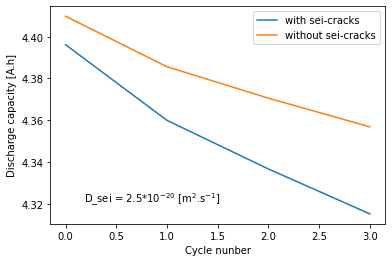

In [7]:
cycle_number1 = []
Qdis_delta1 = []
Qdis_delta2 = []
roughness_cycle = []
porosity1 = []
porosity2 = []
for i in range(total_cycles):
    loc = i*4+1
    t1 = solution1.sub_solutions[loc]["Time [h]"].entries
    Qdis1 = solution1.sub_solutions[loc]["Discharge capacity [A.h]"].entries
    Qdis_delta1.append(Qdis1[-1]-Qdis1[0])
    cycle_number1.append(i)
    roughness = solution1.sub_solutions[loc]["Negative electrode roughness ratio"].entries
    roughness_cycle.append(roughness[0:-1,-1])
    t2 = solution2.sub_solutions[loc]["Time [h]"].entries
    Qdis2 = solution2.sub_solutions[loc]["Discharge capacity [A.h]"].entries
    Qdis_delta2.append(Qdis2[-1]-Qdis2[0])
    poro_temp = solution1.sub_solutions[loc]["Negative electrode porosity"].entries
    porosity1.append(poro_temp[0:-1,-1])
    poro_temp = solution2.sub_solutions[loc]["Negative electrode porosity"].entries
    porosity2.append(poro_temp[0:-1,-1])
plt.figure()
plt.plot(cycle_number1, Qdis_delta1,label='with sei-cracks')
plt.plot(cycle_number1, Qdis_delta2,label='without sei-cracks')
plt.xlabel("Cycle nunber")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()
plt.annotate('D_sei = 2.5*10$^{-20}$ [m$^2$.s$^{-1}$]', xy=(0.1, 0.1),  xycoords='axes fraction',
            )
plt.show()

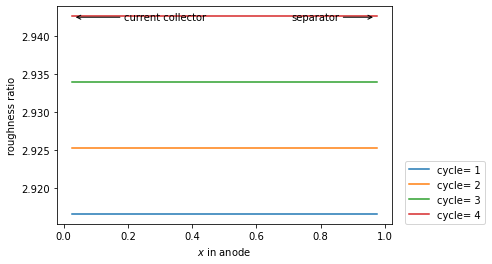

In [8]:
plt.figure()
for i in range(0,total_cycles,int(total_cycles/4)):
    plt.plot(np.arange(1/38,1,1/19), roughness_cycle[i],label='cycle= '+str(i+1))
plt.xlabel("$x$ in anode")
plt.ylabel("roughness ratio")
plt.legend(loc=(1.04,0))
plt.annotate('current collector', xy=(0.05, 0.95),  xycoords='axes fraction',
            xytext=(0.2, 0.95), textcoords='axes fraction',va="center", ha="left",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )
plt.annotate('separator', xy=(0.95, 0.95),  xycoords='axes fraction',
            xytext=(0.7, 0.95), textcoords='axes fraction',va="center", ha="left",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )
plt.show()
# roughness = a_n / a_n0 which is the ratio of surface of particles to surface of ideally spherical particles 
# graphite surface per mass is 10 m^2/g, which means roughness = 13 in Purewal et al.

In [9]:
t_all = solution1["Time [s]"].entries
x = solution1["x [m]"].entries[0:19, 0]
stress_t_n_surf = solution1["Negative particle surface tangential stress"]
print(stress_t_n_surf(t=t_all, x=x[0]))

[5.78050306e-18 2.09159018e-04 2.09320213e-04 ... 7.67212872e-07
 8.41561149e-07 9.01297288e-07]


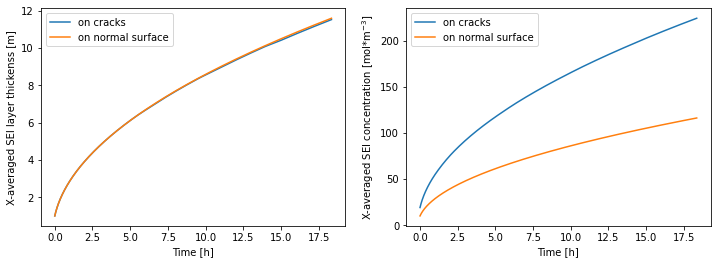

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(12,4))
ax1.plot(solution1["Time [h]"].entries,
        solution1["X-averaged total negative electrode sei-cracks thickness"].entries, label="on cracks")
ax1.plot(solution1["Time [h]"].entries,
        solution1["X-averaged total negative electrode sei thickness"].entries, label="on normal surface")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("X-averaged SEI layer thickenss [m]")
ax1.legend()

ax2.plot(solution1["Time [h]"].entries,
        solution1["X-averaged negative electrode sei-cracks concentration [mol.m-3]"].entries, label="on cracks")
ax2.plot(solution1["Time [h]"].entries,
        solution1["X-averaged negative electrode sei concentration [mol.m-3]"].entries, label="on normal surface")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("X-averaged SEI concentration [mol*m$^{-3}$]")
ax2.legend()
plt.show()

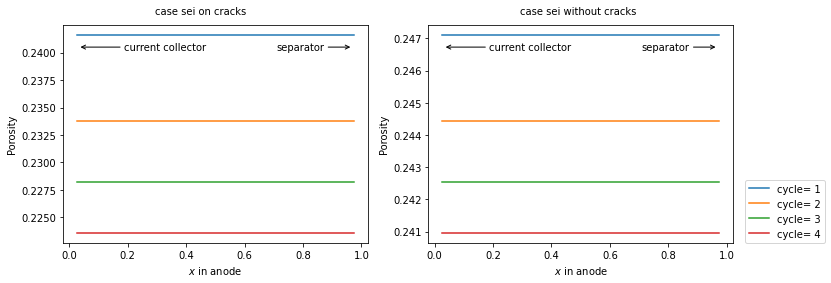

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(12,4))
for i in range(0,total_cycles,int(total_cycles/4)):
    ax1.plot(np.arange(1/38,1,1/19), porosity1[i],label='cycle= '+str(i+1))
ax1.set_xlabel("$x$ in anode")
ax1.set_ylabel("Porosity")
# ax1.legend(loc=(1.04,0))
ax1.annotate('current collector', xy=(0.05, 0.9),  xycoords='axes fraction',
            xytext=(0.2, 0.9), textcoords='axes fraction',va="center", ha="left",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )
ax1.annotate('separator', xy=(0.95, 0.9),  xycoords='axes fraction',
            xytext=(0.7, 0.9), textcoords='axes fraction',va="center", ha="left",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )
ax1.annotate('case sei on cracks', xy=(0.3, 1.05),  xycoords='axes fraction',
            )

for i in range(0,total_cycles,int(total_cycles/4)):
    ax2.plot(np.arange(1/38,1,1/19), porosity2[i],label='cycle= '+str(i+1))
ax2.set_xlabel("$x$ in anode")
ax2.set_ylabel("Porosity")
ax2.legend(loc=(1.04,0))
ax2.annotate('current collector', xy=(0.05, 0.9),  xycoords='axes fraction',
            xytext=(0.2, 0.9), textcoords='axes fraction',va="center", ha="left",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )
ax2.annotate('separator', xy=(0.95, 0.9),  xycoords='axes fraction',
            xytext=(0.7, 0.9), textcoords='axes fraction',va="center", ha="left",
            arrowprops=dict(arrowstyle="->",connectionstyle="arc3"),
            )
ax2.annotate('case sei without cracks', xy=(0.3, 1.05),  xycoords='axes fraction',
            )
plt.show()

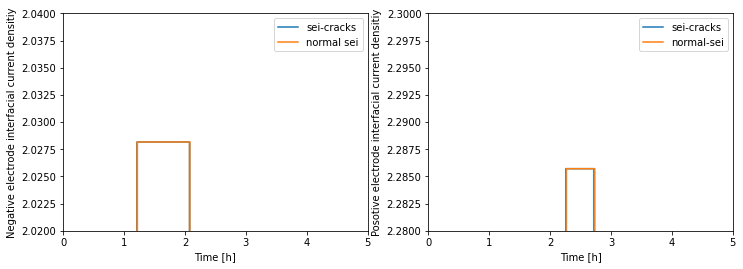

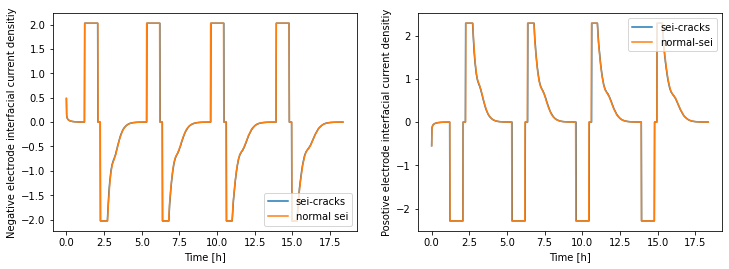

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(12,4))
ax1.plot(solution1["Time [h]"].entries,
        solution1["Sum of negative electrode interfacial current densities"].entries[19,:], label="sei-cracks")
ax1.plot(solution2["Time [h]"].entries,
        solution2["Sum of negative electrode interfacial current densities"].entries[19,:], label="normal sei")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Negative electrode interfacial current densitiy")
ax1.legend()
ax1.set_xlim(0,5)
ax1.set_ylim(2.02,2.04)

ax2.plot(solution1["Time [h]"].entries,
        solution1["Sum of positive electrode interfacial current densities"].entries[0,:], label="sei-cracks")
ax2.plot(solution2["Time [h]"].entries,
        solution2["Sum of positive electrode interfacial current densities"].entries[0,:], label="normal-sei")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Posotive electrode interfacial current densitiy")
ax2.set_xlim(0,5)
ax2.set_ylim(2.28,2.30)
ax2.legend()
plt.show()

f, (ax1, ax2) = plt.subplots(1, 2 ,figsize=(12,4))
ax1.plot(solution1["Time [h]"].entries,
        solution1["Sum of negative electrode interfacial current densities"].entries[19,:], label="sei-cracks")
ax1.plot(solution2["Time [h]"].entries,
        solution2["Sum of negative electrode interfacial current densities"].entries[19,:], label="normal sei")
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Negative electrode interfacial current densitiy")
ax1.legend()

ax2.plot(solution1["Time [h]"].entries,
        solution1["Sum of positive electrode interfacial current densities"].entries[0,:], label="sei-cracks")
ax2.plot(solution2["Time [h]"].entries,
        solution2["Sum of positive electrode interfacial current densities"].entries[0,:], label="normal-sei")
ax2.set_xlabel("Time [h]")
ax2.set_ylabel("Posotive electrode interfacial current densitiy")
ax2.legend()
plt.show()

In [13]:
# solve with the default parameters for the SEI model
print(solution1["X-averaged total negative electrode sei-cracks thickness [m]"].entries)
      
param.update({"Outer SEI solvent diffusivity [m2.s-1]": 2.5e-22})
param2.update({"Outer SEI solvent diffusivity [m2.s-1]": 2.5e-22})
sim3 = pybamm.Simulation(model, experiment=experiment,parameter_values=param)
solution3 = sim3.solve()
sim4 = pybamm.Simulation(model2, experiment=experiment,parameter_values=param2)
solution4 = sim4.solve()



[2.50000000e-09 2.64726039e-09 2.78674955e-09 ... 2.87971741e-08
 2.88103308e-08 2.88214985e-08]


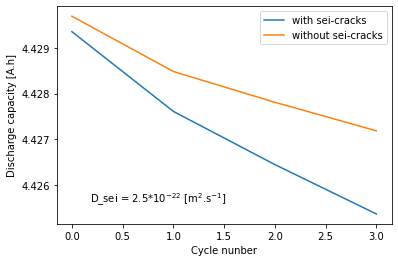

In [14]:
cycle_number1 = []
Qdis_delta1 = []
Qdis_delta2 = []
roughness_cycle = []
for i in range(total_cycles):
    loc = i*4+1
    t1 = solution3.sub_solutions[loc]["Time [h]"].entries
    Qdis1 = solution3.sub_solutions[loc]["Discharge capacity [A.h]"].entries
    Qdis_delta1.append(Qdis1[-1]-Qdis1[0])
    cycle_number1.append(i)
    roughness = solution3.sub_solutions[loc]["Negative electrode roughness ratio"].entries
    roughness_cycle.append(roughness[0:-1,-1])
    t2 = solution4.sub_solutions[loc]["Time [h]"].entries
    Qdis2 = solution4.sub_solutions[loc]["Discharge capacity [A.h]"].entries
    Qdis_delta2.append(Qdis2[-1]-Qdis2[0])
plt.figure()
plt.plot(cycle_number1, Qdis_delta1,label='with sei-cracks')
plt.plot(cycle_number1, Qdis_delta2,label='without sei-cracks')
plt.xlabel("Cycle nunber")
plt.ylabel("Discharge capacity [A.h]")
plt.legend()
plt.annotate('D_sei = 2.5*10$^{-22}$ [m$^2$.s$^{-1}$]', xy=(0.1, 0.1),  xycoords='axes fraction',
            )
plt.show()